In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from algos.alg_fpd_extended import FpdExtended
import numpy as np
from bitarray import bitarray, util
import tqdm
import struct
from shapely.geometry import shape
from collections import defaultdict
import math
import random
from algos.fpd_extended_lib.compress import *

100%|██████████| 10259/10259 [00:06<00:00, 1557.81it/s]


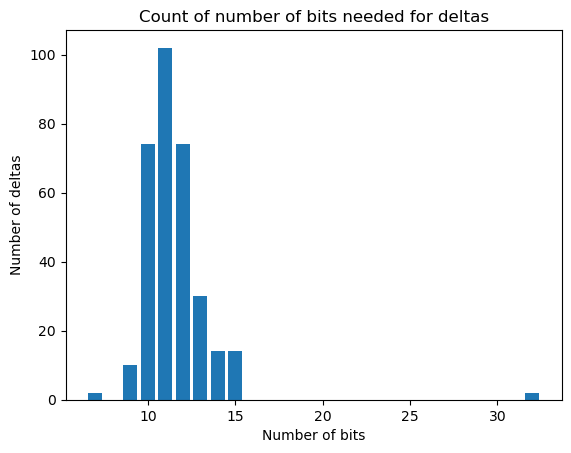

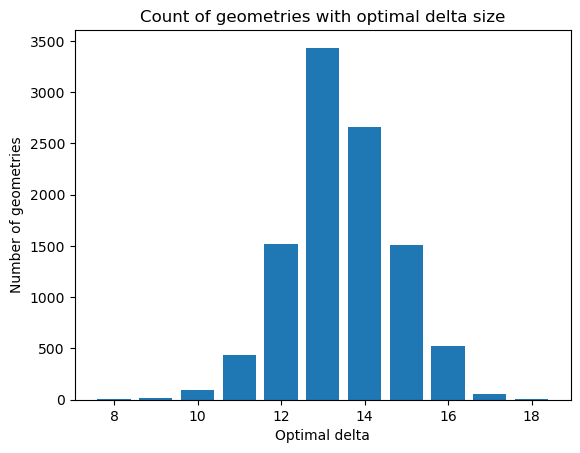

In [2]:
fpd = FpdExtended()

import bench_utils
df, unary_idxs = bench_utils.read_dataset("data/lund_building_highway.json")
#df, unary_idxs = bench_utils.read_dataset("data/world.json")
unary_idxs = list(set(unary_idxs))
bins = []

bit_count = defaultdict(int)
bit_count_by_delta_size = defaultdict(int)
deltas_fp = []
deltas_long = []
geom_optimal_sizes = {}
# Compress files, benchmark unaries
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    opt_size, bit_count, deltas = calculate_delta_size(shape(df.iloc[idx]), True)
    geom_optimal_sizes[idx] = opt_size
    deltas_fp += deltas[0]
    deltas_long += deltas[1]
    for bit_count_key in bit_count:
        bit_count[bit_count_key] += bit_count[bit_count_key]
    bit_count_by_delta_size[opt_size] += 1
    bins.append(fpd.compress(shape(df.iloc[idx]))[1])
plt.bar(bit_count.keys(), bit_count.values());
plt.title("Count of number of bits needed for deltas")
plt.xlabel("Number of bits")
plt.ylabel("Number of deltas")
plt.show()

plt.bar(bit_count_by_delta_size.keys(), bit_count_by_delta_size.values());
plt.title("Count of geometries with optimal delta size")
plt.xlabel("Optimal delta")
plt.ylabel("Number of geometries")
plt.show()
deltas_fp = np.array(deltas_fp)

Percentage of total FP deltas within filtered 0.7848072590125392
Percentage of total FP deltas (but removed excessive values) within filtered 0.8975631958546321
Percentage of total LONG + ZZ deltas within filtered 0.8513788205329154
Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered 0.8513788205329154


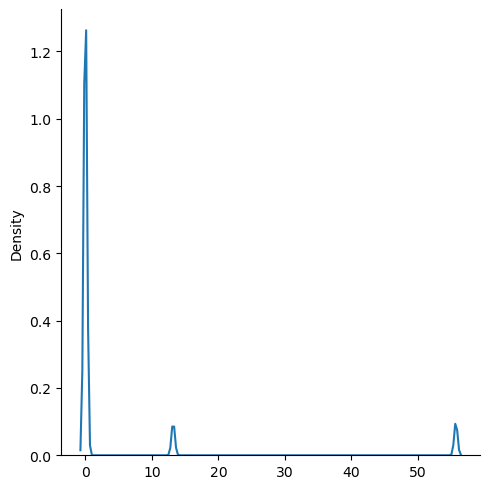

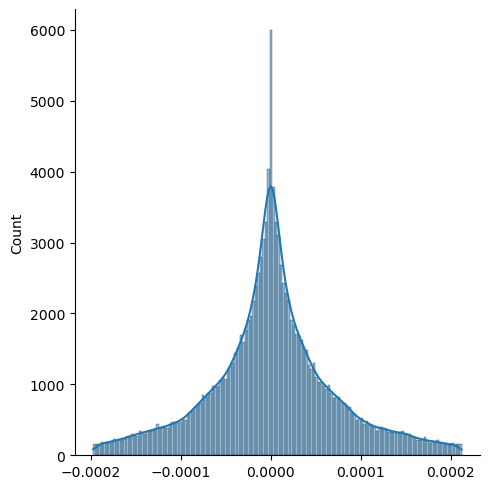

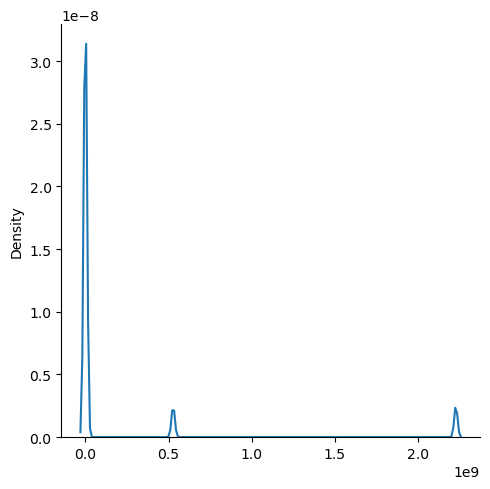

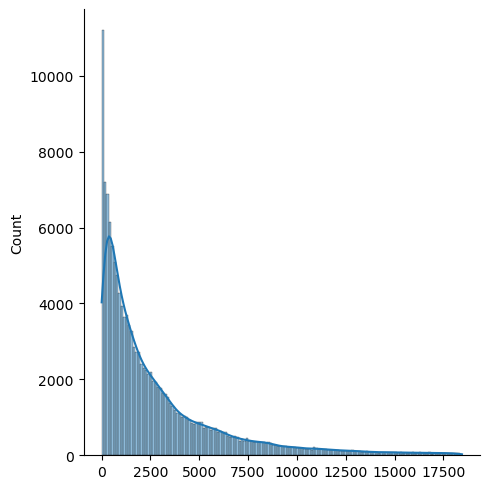

In [3]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

OUTLIER_THRESHOLD = 2.5
filtered = np.array(deltas_fp)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_fp, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total FP deltas within filtered", len(filtered) / len(deltas_fp))
print("Percentage of total FP deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_fp[deltas_fp < 10]))

OUTLIER_THRESHOLD = 6
deltas_long_np = np.array(deltas_long, dtype=np.float64)
filtered = np.array(deltas_long_np)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_long_np, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total LONG + ZZ deltas within filtered", len(filtered) / len(deltas_long_np))
print("Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_long_np[deltas_long_np < 4 * pow(10, 18)]))

In [4]:
for i in range(1):
    idx = random.randint(0, len(deltas_fp))
    print("---")
    print("Delta in FP and LONG:    ", f'{deltas_fp[idx]:.14f}', '        ', deltas_long[idx])
    print("Converting to f32:       ", f'{struct.unpack("!f", struct.pack("!f", deltas_fp[idx]))[0]:.14f}')
    print("Required bits:           ", math.ceil(math.log2(deltas_long[idx] + 1)))
    bin = util.int2ba(deltas_long[idx], length=64)
    print("ZZ-encoded:              ", end=None)
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP directly to bin:      ", end=None)
    bin.frombytes(struct.pack("!d", deltas_fp[idx]))
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP32 directly to bin:    ", end=None)
    bin.frombytes(struct.pack("!f", deltas_fp[idx]))
    
    util.pprint(bin, width=200)

---
Delta in FP and LONG:     13.21667760000000          528667104
Converting to f32:        13.21667766571045
Required bits:            29
ZZ-encoded:              
bitarray('00000000 00000000 00000000 00000000 00011111 10000010 11010001 11100000')
FP directly to bin:      
bitarray('01000000 00101010 01101110 11110000 01011101 11001011 10001101 00110010')
FP32 directly to bin:    
bitarray('01000001 01010011 01110111 10000011')


In [5]:
if False:
    from intersection.plotting import *

    for i in range(2):
        idx = random.randint(0, len(bins))
        plot_chunks_bounds(bins[idx], include_next_chunk_start=False)
        plot_chunks_bounds(bins[idx], include_next_chunk_start=True)

## Entrpoy Encoding Analysis

In [6]:
import warnings
from collections import defaultdict
import tqdm
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

In [7]:

#Fill list of previous variables
def get_delta_frequencies():
    #Created stats variables for all deltas in general, by geometry and by bits delta is encoded with (optimal size)
    delta_freqs = []
    delta_01_freqs = []
    delta_freqs_by_bits = defaultdict(list)
    delta_freqs_by_geometry = defaultdict(dict)
    for idx in tqdm.tqdm(unary_idxs): # List of single idxs
        opt_size, _, deltas = calculate_delta_size(shape(df.iloc[idx]), True)
        for delta in deltas[1]:
            #If coordinate not delta_encoded
            if delta != 0 and math.log2(delta) > opt_size:
                continue
            delta_freqs.append(delta)
            delta_01_freqs.append(uint_to_ba(delta,opt_size).to01())
            delta_freqs_by_bits[opt_size].append(delta)
            if delta in delta_freqs_by_geometry[idx]:
                delta_freqs_by_geometry[idx][delta] += 1
            else:
                delta_freqs_by_geometry[idx][delta] = 1
                
    return delta_freqs, delta_01_freqs, delta_freqs_by_bits, delta_freqs_by_geometry


In [8]:
def plot_delta_distribution(delta_freqs, delta_freqs_by_bits):
    plt.title("Global delta distribution")
    ax = sns.kdeplot(delta_freqs)
    ax.set_xlim(0, max(delta_freqs))
    plt.show()

    HEIGHT = math.ceil(math.sqrt(len(delta_freqs_by_bits.keys()))) 
    WIDTH = HEIGHT
    fig, axes = plt.subplots(WIDTH, HEIGHT)

    for idx, delta_bit_len in enumerate(sorted(delta_freqs_by_bits.keys())):
        curr_height, curr_width = idx // HEIGHT, idx % WIDTH
        current_axis = axes[curr_height, curr_width]

        current_axis.set_title("delta size: {}".format(delta_bit_len),pad=10)
        ax = sns.kdeplot(delta_freqs_by_bits[delta_bit_len], ax=current_axis)
        current_axis.set_xlim(0, max(delta_freqs_by_bits[delta_bit_len]))
        current_axis.set(ylabel=None)

    fig.supylabel('Density')
    fig.supxlabel('Delta values')
    fig.suptitle('Distribution of delta values for different delta bit lengths')
    fig.set_figwidth(HEIGHT * 3)
    fig.set_figheight(HEIGHT * 3)

    plt.tight_layout()

    plt.show()

100%|██████████| 10259/10259 [00:02<00:00, 4316.68it/s]


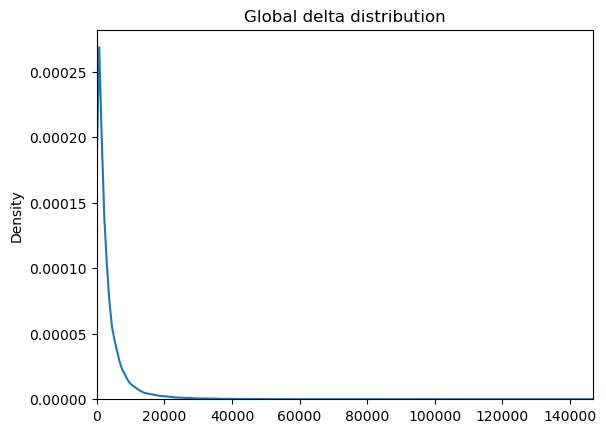

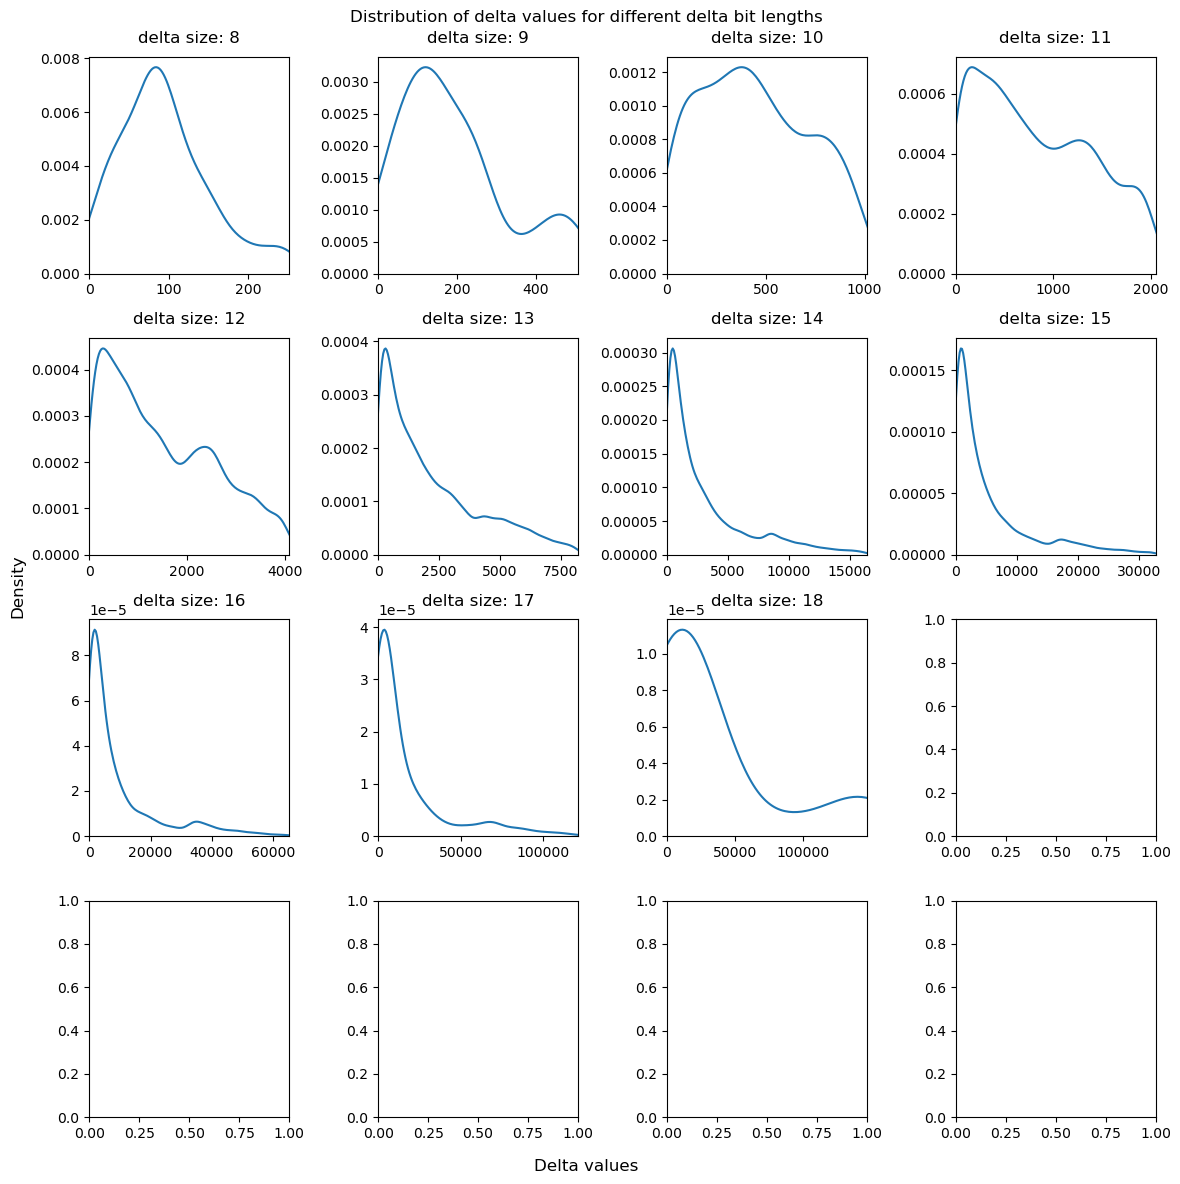

In [9]:
delta_freqs, delta_01_freqs, delta_freqs_by_bits, delta_freqs_by_geometry = get_delta_frequencies()
plot_delta_distribution(delta_freqs, delta_freqs_by_bits)

#### Delta prefix analysis

In [10]:
PREFIX_LENGTH = 6
prefix_freqs_by_bits = None
prefix_freqs = None

def get_entropy_codes(frequency_list):
    codes = util.canonical_huffman(frequency_list)
    return codes[0]

def calculate_prefix_counts(prefix_len):
    cnt_prefix_by_bits = defaultdict(dict)
    cnt_prefix = defaultdict(int)
    for opt_size in tqdm.tqdm(delta_freqs_by_bits):
        deltas = delta_freqs_by_bits[opt_size]
        for d in deltas:
            bits = uint_to_ba(d,opt_size)
            prefix_bits = bits[:prefix_len].to01()
            cnt_prefix[prefix_bits] += 1
            if prefix_bits in cnt_prefix_by_bits[opt_size]:
                cnt_prefix_by_bits[opt_size][prefix_bits] += 1
            else:
                cnt_prefix_by_bits[opt_size][prefix_bits] = 1
    return cnt_prefix_by_bits, cnt_prefix

prefix_freqs_by_bits, prefix_freqs = calculate_prefix_counts(PREFIX_LENGTH)


100%|██████████| 11/11 [00:00<00:00, 39.95it/s]


In [11]:
global_codes =  get_entropy_codes(prefix_freqs)
codes_by_bits = {opt_size: get_entropy_codes(prefix_freqs_by_bits[opt_size]) for opt_size in prefix_freqs_by_bits}


In [12]:

def plot_prefix_freq(prefix_freq):
    #Plot global data
    dictionary = dict(sorted(prefix_freq.items(), key=lambda x:-x[1]))
    plt.figure(figsize=(20,6))
    plt.bar(dictionary.keys(), dictionary.values())

    plt.title("Global prefix bits count -> Huffman codes")
    plt.xlabel("Bit sequence")
    plt.ylabel("Count")
    plt.xticks(plt.xticks()[0], ["{}  ->  {}".format(key,global_codes[key].to01()) for key in dictionary.keys()], rotation = 90)
    plt.tight_layout()
    plt.show()


def plot_prefix_freq_by_bits(prefix_freq_by_bits):

    #Plot delta size specific data
    HEIGHT, WIDTH = len(prefix_freq_by_bits) // 2 + len(prefix_freq_by_bits) % 2, 2
    fig, axs = plt.subplots(HEIGHT, WIDTH, sharex=False, sharey=False)

    for idx, opt_delta in tqdm.tqdm(enumerate(sorted(prefix_freq_by_bits))):
        dictionary = dict(sorted(prefix_freq_by_bits[opt_delta].items(), key=lambda x:-x[1]))
        curr_codes = codes_by_bits[opt_delta]
        curr_ax_height, curr_ax_width = idx // 2, idx % 2
        axs[curr_ax_height, curr_ax_width].bar(dictionary.keys(), dictionary.values())
        axs[curr_ax_height, curr_ax_width].set_title("Delta size: {}".format(opt_delta))      
        axs[curr_ax_height, curr_ax_width].set_xticklabels(["{}  ->  {}".format(key,curr_codes[key].to01()) for key in dictionary.keys()], rotation = 90)
    
    fig.suptitle("Opt-size prefix bits count -> Huffman code for different delta sizes", fontsize=16)
    fig.supylabel('Count')
    fig.supxlabel('Bit sequence')
    fig.tight_layout()
    fig.set_figheight(4 * HEIGHT)
    fig.set_figwidth(20)
    fig.tight_layout(pad=0.1)
    plt.tight_layout()
    fig.subplots_adjust(top=0.95, bottom=0.1, left=0.1)
    plt.show()

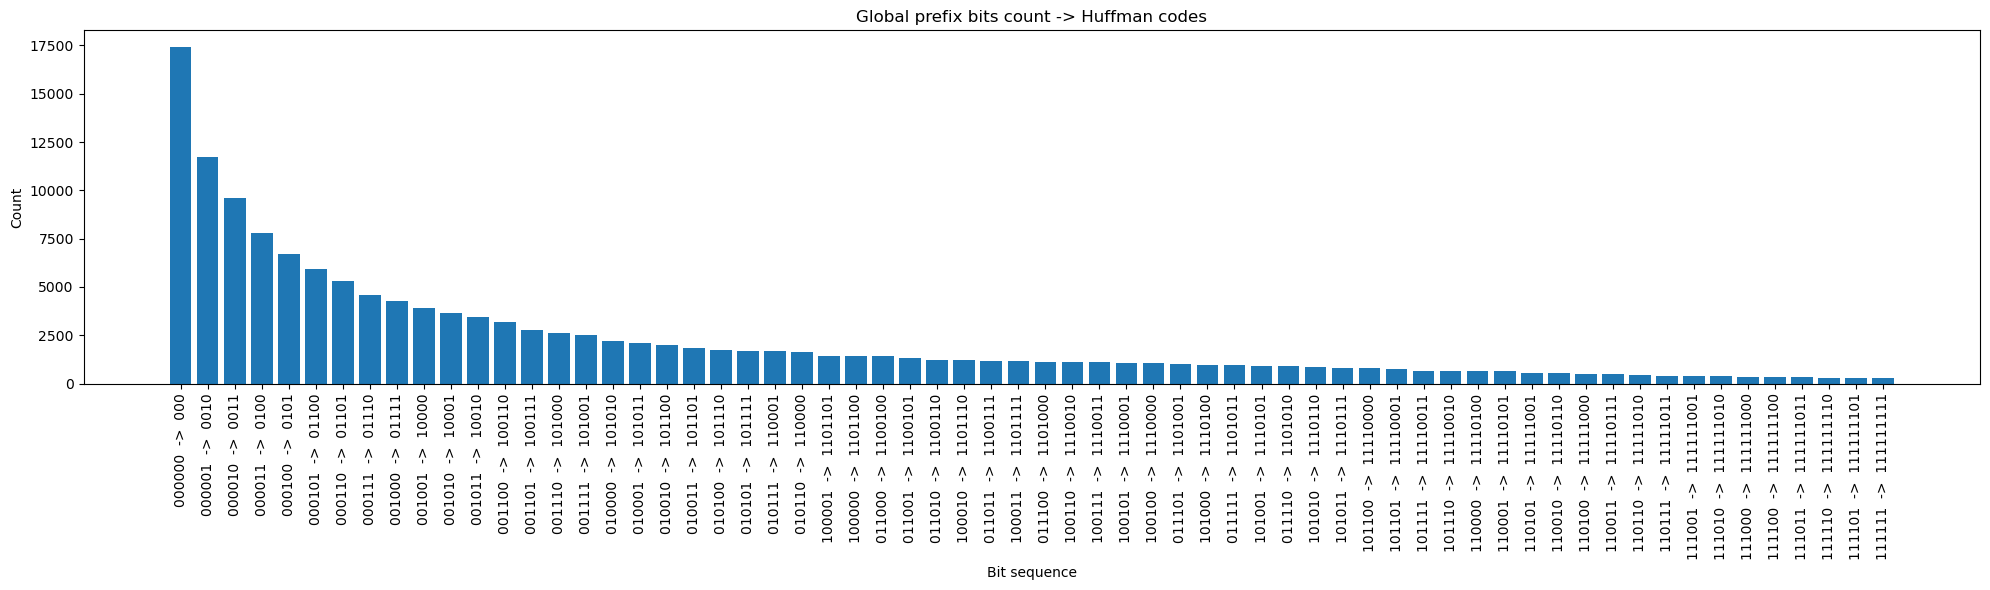

In [13]:
plot_prefix_freq(prefix_freqs)


11it [00:00, 12.54it/s]


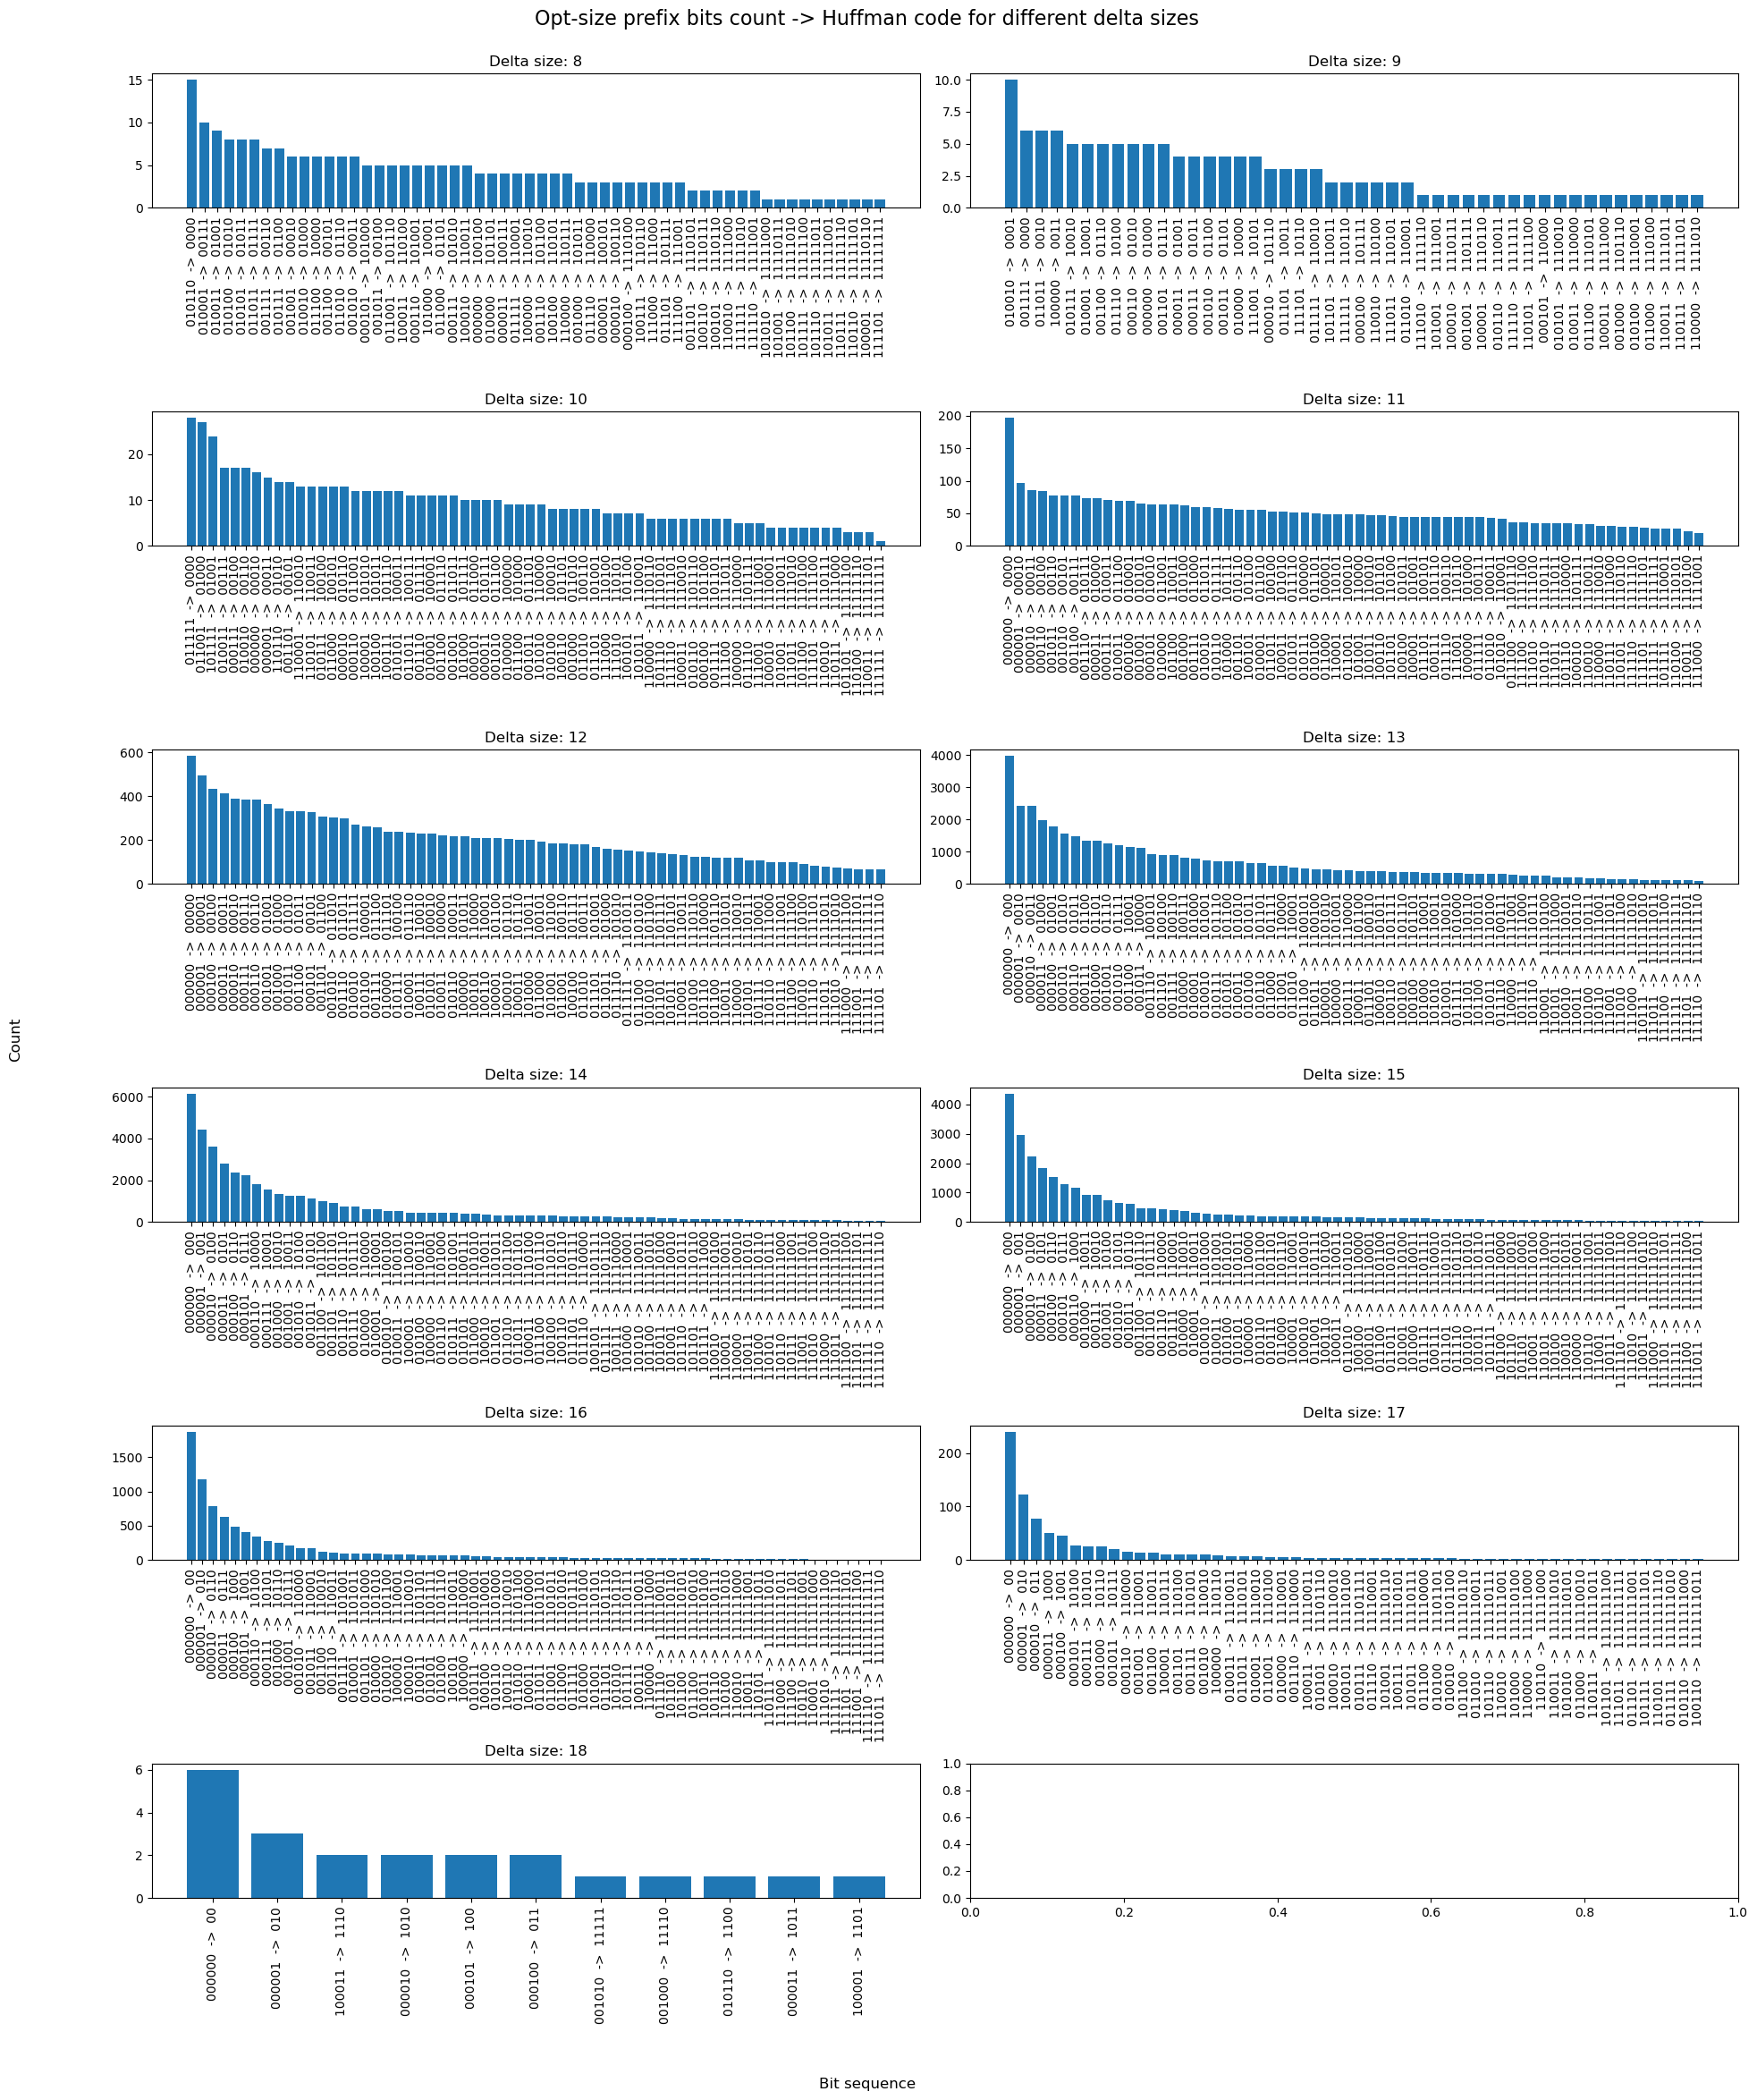

In [14]:
plot_prefix_freq_by_bits(prefix_freqs_by_bits)

In [15]:

def prefix_diff_calc(codes, bit_freqs):
    diff_count = defaultdict(int)
    pos_neg_count = {'Removed':0, 'Added':0} 
    for bits_to_codes in codes:
        diff = len(codes[bits_to_codes].to01()) - len(bits_to_codes)
        bits_to_code_cnt = bit_freqs[bits_to_codes]
        bits_diff = bits_to_code_cnt * abs(diff)

        if diff in diff_count:
            diff_count[diff] += bits_to_code_cnt
        else:
            diff_count[diff] = bits_to_code_cnt
        if diff < 0:
            pos_neg_count["Removed"] += bits_diff
        if diff > 0:
            pos_neg_count["Added"] += bits_diff 
            
    return diff_count, pos_neg_count

def prefix_diff_calc_by_bits():
    diff_count = defaultdict(dict)
    pos_neg_count = defaultdict(dict)
    for opt_size in dict(sorted(prefix_freqs_by_bits.items(), key=lambda x:x[0])):
        diff_count[opt_size], pos_neg_count[opt_size] = prefix_diff_calc(codes_by_bits[opt_size], prefix_freqs_by_bits[opt_size])            
    return diff_count, pos_neg_count

def set_subplt_fig_attributes(fig, title, y_label, x_label, x_size, y_size):
    fig.suptitle(title)
    fig.supylabel(y_label)
    fig.supxlabel(x_label)
    fig.tight_layout()
    fig.set_figheight(y_size)
    fig.set_figwidth(x_size)
    plt.tight_layout()

def set_fig_attributes(title, y_label, x_label):
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.tight_layout()


In [16]:
prefix_diff_count_by_bits, prefix_pos_neg_count_by_bits =  prefix_diff_calc_by_bits()

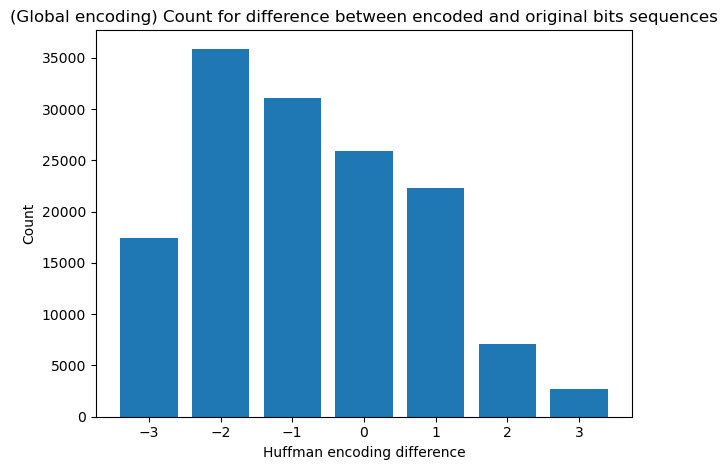

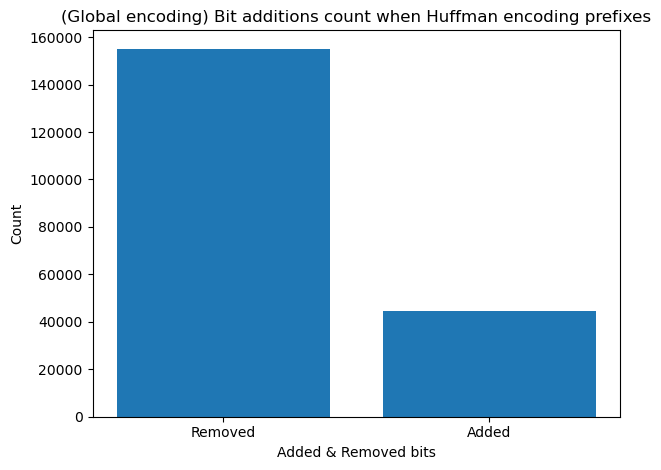

In [17]:

global_prefix_diff_count, global_prefix_pos_neg_count = prefix_diff_calc(global_codes, prefix_freqs)


plt.bar(global_prefix_diff_count.keys(),global_prefix_diff_count.values())
plt.ylabel
set_fig_attributes("(Global encoding) Count for difference between encoded and original bits sequences", 'Count', 'Huffman encoding difference')       
plt.show()

plt.bar(global_prefix_pos_neg_count.keys(),global_prefix_pos_neg_count.values())
set_fig_attributes("(Global encoding) Bit additions count when Huffman encoding prefixes", 'Count', 'Added & Removed bits')     
plt.show()

11it [00:00, 47.17it/s]


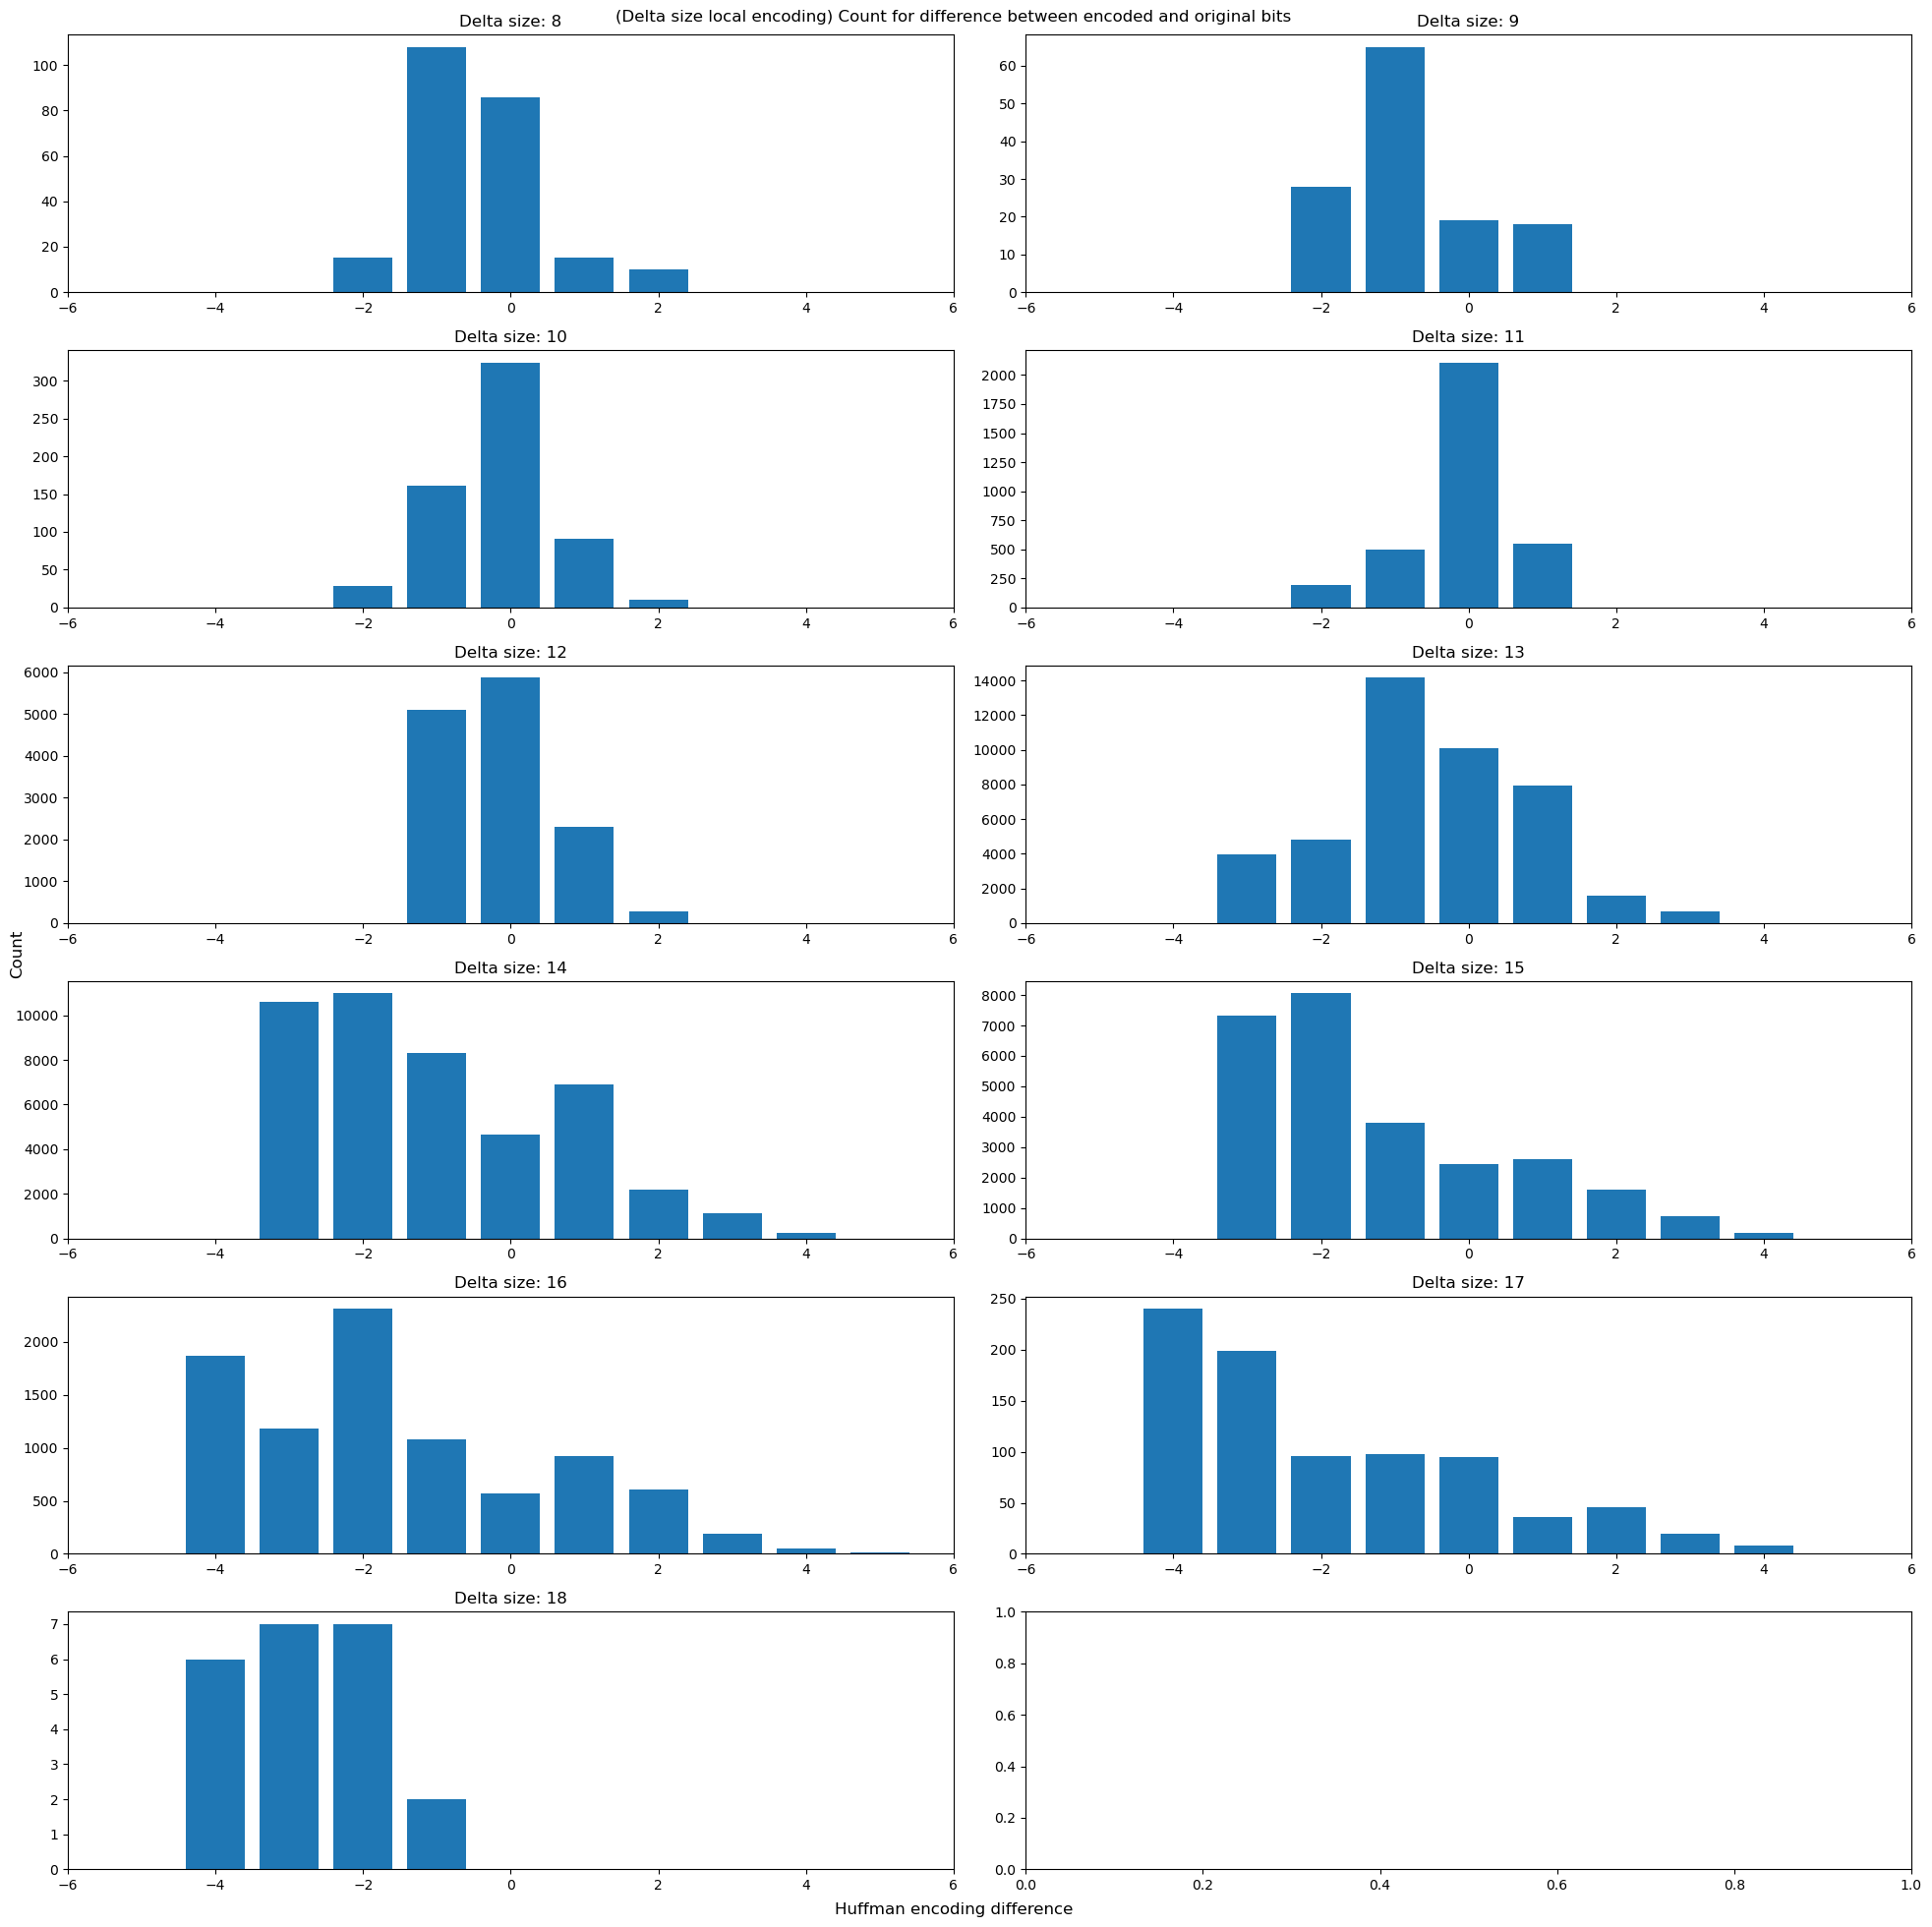

11it [00:00, 484.33it/s]


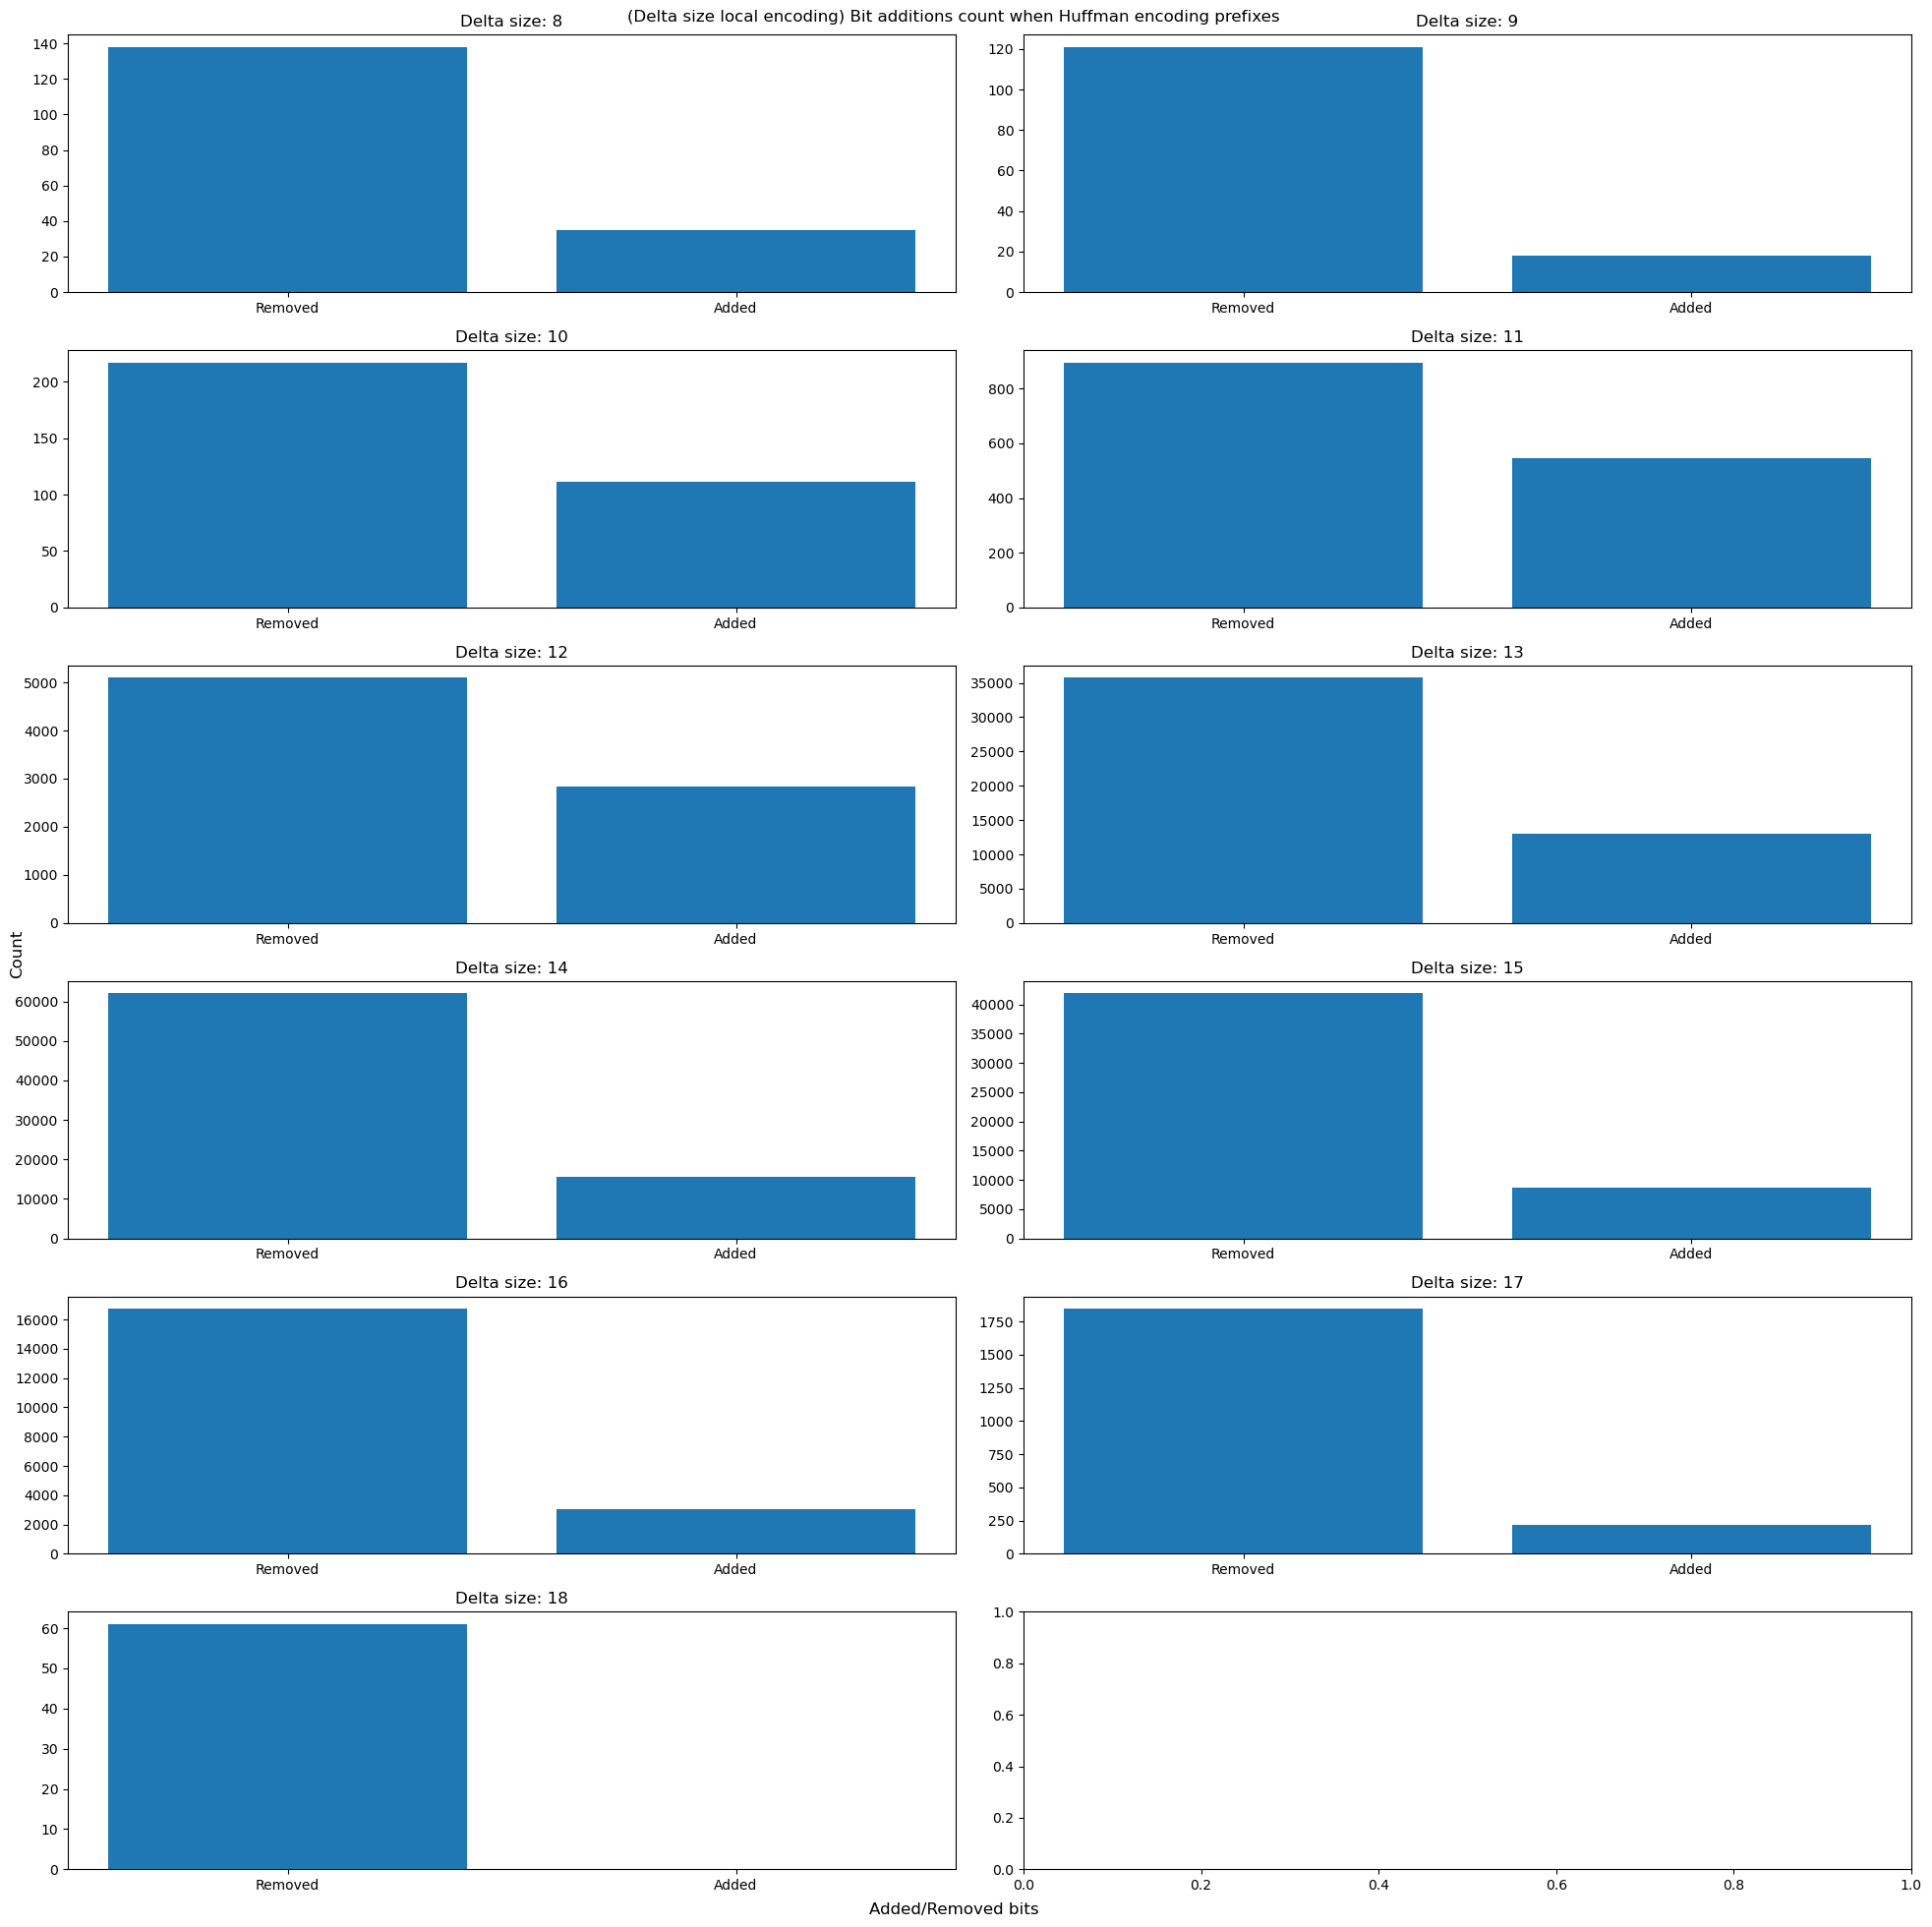

In [18]:
HEIGHT, WIDTH = len(prefix_diff_count_by_bits) // 2 + len(prefix_diff_count_by_bits) % 2, 2
fig, axs = plt.subplots(HEIGHT, WIDTH, sharex=False, sharey=False)

for idx, opt_delta in tqdm.tqdm(enumerate(prefix_diff_count_by_bits)):
    dictionary = dict(sorted(prefix_diff_count_by_bits[opt_delta].items(), key=lambda x:-x[1]))
    axs[idx // 2,idx % 2].bar(dictionary.keys(), dictionary.values())
    axs[idx // 2,idx % 2].set_title("Delta size: {}".format(opt_delta)) 
    axs[idx // 2,idx % 2].set_xlim([-6, 6])
set_subplt_fig_attributes(fig,"(Delta size local encoding) Count for difference between encoded and original bits", 'Count', 'Huffman encoding difference', 20, 20)       

plt.show()

HEIGHT = len(prefix_pos_neg_count_by_bits) // 2 + len(prefix_pos_neg_count_by_bits) % 2

fig, axs = plt.subplots(HEIGHT, WIDTH, sharex=False, sharey=False)

for idx, opt_delta in tqdm.tqdm(enumerate(prefix_pos_neg_count_by_bits)):
    dictionary = dict(sorted(prefix_pos_neg_count_by_bits[opt_delta].items(), key=lambda x:-x[1]))
    axs[idx // 2,idx % 2].bar(dictionary.keys(), dictionary.values())
    axs[idx // 2,idx % 2].set_title("Delta size: {}".format(opt_delta))        
set_subplt_fig_attributes(fig,"(Delta size local encoding) Bit additions count when Huffman encoding prefixes", 'Count', 'Added/Removed bits', 20, 20)       



### Entropy encoding advantage analysis

In [19]:
from collections import Counter
full_delta_codes = get_entropy_codes(dict(Counter(delta_01_freqs)))


In [20]:
#EE = "Entropy encoded"
geom_entropy_df = pd.DataFrame(columns=["geom_idx", 
                                        "delta_size", 
                                        "prefix_size", 
                                        "EE(global) delta_size", 
                                        "EE(geom local) prefix_size", 
                                        "EE(delta size local) prefix_size", 
                                        "EE(global) prefix_size"],index=[0])

for geom_idx in delta_freqs_by_geometry:

    geom_deltas_freqs = {uint_to_ba(key, geom_optimal_sizes[geom_idx]).to01():value for key, value in delta_freqs_by_geometry[geom_idx].items()}
    geom_prefix_freqs = {key[:PREFIX_LENGTH]:value for key, value in geom_deltas_freqs.items()}
    
    geom_local_codes = get_entropy_codes(geom_prefix_freqs)
    bits_len_codes = codes_by_bits[geom_optimal_sizes[geom_idx]]
    
    geom_tot_delta_sizes = sum([len(key) * value for key, value in geom_deltas_freqs.items()])
    geom_prefix_sizes = sum([len(key) * value for key, value in geom_prefix_freqs.items()])
    
    global_coding_prefix_freqs = {global_codes[key].to01():value for key, value in geom_prefix_freqs.items()}
    local_coding_prefix_freqs = {geom_local_codes[key].to01():value for key, value in geom_prefix_freqs.items()}
    bits_len_coding_prefix_freqs = {bits_len_codes[key].to01():value for key, value in geom_prefix_freqs.items()}

    geom_prefix_sizes_conv_delta_size_coding = sum([len(bits_len_codes[key]) * value for key, value in geom_prefix_freqs.items()])
    geom_prefix_sizes_conv_global_coding = sum([len(global_codes[key]) * value for key, value in geom_prefix_freqs.items()])
    geom_prefix_sizes_conv_local_coding = sum([len(geom_local_codes[key]) * value for key, value in geom_prefix_freqs.items()])

    global_coding_delta_freqs = {full_delta_codes[key].to01():value for key, value in geom_deltas_freqs.items()}
    geom_tot_delta_sizes_conv = sum([len(full_delta_codes[key]) * value for key, value in geom_deltas_freqs.items()])
    new_row = pd.DataFrame({"geom_idx": geom_idx, 
                            "delta_size":geom_tot_delta_sizes, 
                            "prefix_size": geom_prefix_sizes, 
                            "EE(global) delta_size": geom_tot_delta_sizes_conv, 
                            "EE(geom local) prefix_size": geom_prefix_sizes_conv_local_coding, 
                            "EE(delta size local) prefix_size": geom_prefix_sizes_conv_delta_size_coding, 
                            "EE(global) prefix_size": geom_prefix_sizes_conv_global_coding}, index=[0])   
    geom_entropy_df = pd.concat([new_row,geom_entropy_df])

geom_entropy_df["delta_size_excl_prefix"] = geom_entropy_df["delta_size"] - geom_entropy_df["prefix_size"] 


In [35]:
print("Percentage change of prefixes (geom local encoding + Excl saving huffman tree): ", geom_entropy_df["EE(geom local) prefix_size"].sum() / geom_entropy_df["prefix_size"].sum())
print("Percentage change of prefixes (delta size local encoding): ", geom_entropy_df["EE(delta size local) prefix_size"].sum() / geom_entropy_df["prefix_size"].sum())
print("Percentage change of prefixes (global encoding): ", geom_entropy_df["EE(global) prefix_size"].sum() / geom_entropy_df["prefix_size"].sum())
print("")
print("Percentage change when encoding the whole deltas (global encoding): ", geom_entropy_df["EE(global) delta_size"].sum() / geom_entropy_df["delta_size"].sum())
print("Percentage total change using (geom local encoding + Excl saving huffman tree): ", (geom_entropy_df["EE(geom local) prefix_size"].sum() + geom_entropy_df["delta_size_excl_prefix"].sum())/ geom_entropy_df["delta_size"].sum())
print("Percentage total change using (delta size local encoding): ", (geom_entropy_df["EE(delta size local) prefix_size"].sum() + geom_entropy_df["delta_size_excl_prefix"].sum())/ geom_entropy_df["delta_size"].sum())
print("Percentage total change using (global encoding): ", (geom_entropy_df["EE(global) prefix_size"].sum() + geom_entropy_df["delta_size_excl_prefix"].sum())/ geom_entropy_df["delta_size"].sum())


Percentage change of prefixes (geom local encoding + Excl saving huffman tree):  0.5595653357082777
Percentage change of prefixes (delta size local encoding):  0.9523774182375934
Percentage change of prefixes (global encoding):  0.9548203948344961

Percentage change when encoding the whole deltas (global encoding):  1.0121010515988595
Percentage total change using (geom local encoding + Excl saving huffman tree):  0.8908345341386393
Percentage total change using (delta size local encoding):  0.98819633933225
Percentage total change using (global encoding):  0.9888018517950762


In [30]:
geom_entropy_df

,geom_idx,delta_size,prefix_size,EE(global) delta_size,EE(geom local) prefix_size,EE(delta size local) prefix_size,EE(global) prefix_size,delta_size_excl_prefix
0,16489,4800,174,4512,140,170,166,4626
0,16488,330,96,340,64,100,96,234
0,16487,150,48,161,24,54,51,102
0,16486,308,84,301,54,81,79,224
0,16485,1417,216,1390,188,219,221,1201
...,...,...,...,...,...,...,...,...
0,9,60,24,64,8,26,24,36
0,7,330,84,330,54,78,76,246
0,3,364,108,365,74,100,98,256
0,1,312,48,290,24,41,41,264
